Для поиска интро я предлагаю следующий подход:<br>
Аудио и видео разбивается на фреймы определенного интервала, из этих фреймов получаем эмбеддинги (по отдельности), эти эмбеддинги объединяются и подаются в предиктор, например, простую CNN.<br>
В итоге, получаем вероятности быть интро для всех кадров.<br>

In [48]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import librosa
from transformers import AutoProcessor, AutoModel
import torchvision.transforms as T
from PIL import Image

Функция для получения фреймов

In [39]:
def extract_video_frames(video_path, frame_duration=1.0):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = total_frames / fps

    frames = []
    timestamps = []

    current_time = 0.0
    while current_time < video_duration:
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        timestamps.append(current_time)
        current_time += frame_duration

    cap.release()

    audio, sr = librosa.load(video_path, sr=16000)
    audio_chunks = []
    for ts in timestamps:
        start_sample = int(ts * sr)
        end_sample = int((ts + frame_duration) * sr)
        chunk = audio[start_sample:end_sample]
        chunk = librosa.util.fix_length(chunk, size=int(frame_duration * sr))
        audio_chunks.append(chunk)

    return frames, audio_chunks, timestamps


In [40]:
frames, audio_chunks, timestamps = extract_video_frames("/content/-220020068_456249220.mp4")

<ipython-input-39-302975361>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(video_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


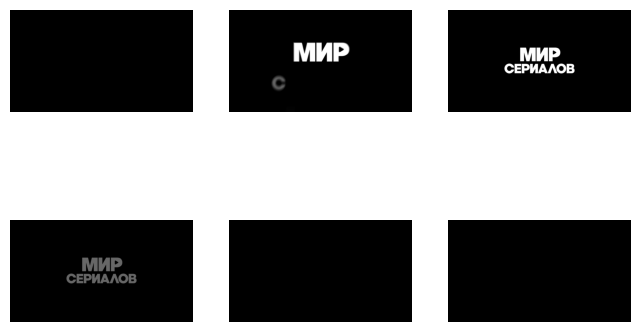

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(8, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(frames[i])
    ax.axis('off')

plt.show()

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Получение видео эмбеддингов с помощью dinov2, аудио - MFCC

In [43]:
processor = AutoProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base").to(device).eval()

transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_video_embedding(frame: np.ndarray) -> np.ndarray:
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

def get_audio_embedding(audio, sr=16000):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    return np.mean(mfcc, axis=1)

In [44]:
video_embs = [get_video_embedding(frame) for frame in frames]
audio_embs = [get_audio_embedding(audio) for audio in audio_chunks]

In [45]:
video_embs[0].shape, audio_embs[0].shape

((768,), (20,))

Конкатенирую эмбеддинги

In [46]:
features = []
for v_emb, a_emb in zip(video_embs, audio_embs):
        vec = np.concatenate([v_emb, a_emb])
        features.append(vec)
features = torch.tensor(np.array(features), dtype=torch.float32).unsqueeze(0)

In [47]:
features.shape

torch.Size([1, 1002, 788])

Простая сверточная нейронная сеть

In [49]:
class IntroPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.net(x)
        return x.squeeze(1)


Датасет не маленький, так что для примера я проинференсила полученную фичу

In [50]:
model = IntroPredictor(features.shape[2])
model.eval()

with torch.no_grad():
    out = model(features)

In [51]:
out

tensor([[0.6250, 0.5934, 0.8102,  ..., 0.6557, 0.6861, 0.6970]])